In [1]:
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt


In [2]:
n_samples = 1000
X, y = make_circles(n_samples, noise=0.03, random_state=7)

In [3]:
print(X.shape, y.shape)

(1000, 2) (1000,)


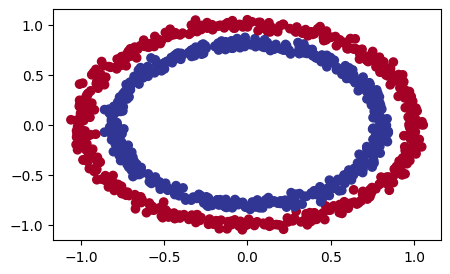

In [4]:
plt.figure(figsize=(5, 3))
plt.scatter(x=X[:, 0], 
            y=X[:, 1], 
            c=y,
            cmap=plt.cm.RdYlBu)

In [5]:
X_sample = X[0]
y_sample = y[0]
print(f"sample x: {X_sample}, sample y: {y_sample}")
print(X_sample.shape, y_sample.shape)

sample x: [-0.75681927 -0.27401115], sample y: 1
(2,) ()


In [6]:
import torch
from torch import nn

In [7]:
X = torch.from_numpy(X).type(dtype=torch.float)
y = torch.from_numpy(y).type(dtype=torch.float)

X[:5], y[:5]

(tensor([[-0.7568, -0.2740],
         [-0.4817, -0.8741],
         [-0.9702, -0.2521],
         [-0.6609, -0.4991],
         [-0.9079,  0.4084]]),
 tensor([1., 0., 0., 1., 0.]))

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=7)

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [10]:
cuda_available = torch.cuda.is_available()
print(f"CUDA Available: {cuda_available}")
mps_available = torch.mps.is_available()
print(f"MPS Available: {mps_available}")
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

CUDA Available: False
MPS Available: True
Using device: mps


In [11]:
class CircleModelV0(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)

    def forward(self, x):
        return self.layer_2(self.layer_1(x))
    
model_0 = CircleModelV0().to(device=device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [12]:
untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[ 0.1098],
        [ 0.1363],
        [-0.1675],
        [-0.1323],
        [ 0.0884],
        [ 0.0960],
        [-0.0709],
        [-0.1814],
        [ 0.0189],
        [-0.0875]], device='mps:0', grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 0., 1., 1., 1., 1., 0., 1., 0.])


In [13]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [14]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred))*100
    return acc

In [15]:
y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[ 0.1098],
        [ 0.1363],
        [-0.1675],
        [-0.1323],
        [ 0.0884]], device='mps:0', grad_fn=<SliceBackward0>)

In [16]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5274],
        [0.5340],
        [0.4582],
        [0.4670],
        [0.5221]], device='mps:0', grad_fn=<SigmoidBackward0>)

In [17]:
y_preds = torch.round(y_pred_probs)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))
y_preds.squeeze()

tensor([True, True, True, True, True], device='mps:0')


tensor([1., 1., 0., 0., 1.], device='mps:0', grad_fn=<SqueezeBackward0>)

In [18]:
y_test[:5]

tensor([1., 0., 0., 1., 1.])

In [19]:
torch.manual_seed(7)

epochs = 1000
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model_0.train()

    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # BCELoss, BCEWithLogits are diff in sigmoid application
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_train, y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_0.eval()
    with torch.inference_mode():
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_test, test_pred)
        if epoch%100 == 0:
            print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69431, Accuracy: 49.75% | Test loss: 0.69654, Test acc: 50.00%
Epoch: 100 | Loss: 0.69330, Accuracy: 47.25% | Test loss: 0.69867, Test acc: 46.50%
Epoch: 200 | Loss: 0.69298, Accuracy: 44.75% | Test loss: 0.69838, Test acc: 38.50%
Epoch: 300 | Loss: 0.69283, Accuracy: 50.00% | Test loss: 0.69824, Test acc: 42.50%
Epoch: 400 | Loss: 0.69275, Accuracy: 51.62% | Test loss: 0.69817, Test acc: 43.50%
Epoch: 500 | Loss: 0.69269, Accuracy: 51.62% | Test loss: 0.69813, Test acc: 43.50%
Epoch: 600 | Loss: 0.69266, Accuracy: 51.62% | Test loss: 0.69810, Test acc: 43.50%
Epoch: 700 | Loss: 0.69264, Accuracy: 51.62% | Test loss: 0.69809, Test acc: 43.50%
Epoch: 800 | Loss: 0.69263, Accuracy: 51.62% | Test loss: 0.69808, Test acc: 43.50%
Epoch: 900 | Loss: 0.69262, Accuracy: 51.62% | Test loss: 0.69808, Test acc: 43.50%


In [20]:
from helper_functions import plot_predictions, plot_decision_boundary

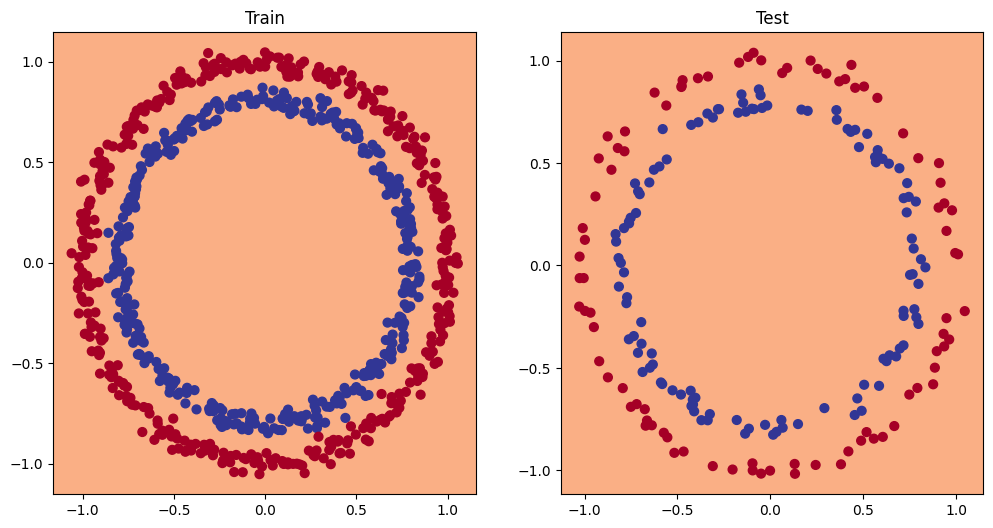

In [21]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

In [22]:
class CircleModelV1(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x):
        return self.layer_3(self.layer_2(self.layer_1(x)))
    
model_1 = CircleModelV1().to(device=device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [23]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

In [24]:
torch.manual_seed(7)

epochs = 1000
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model_1.train()

    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # BCELoss, BCEWithLogits are diff in sigmoid application
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_train, y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_1.eval()
    with torch.inference_mode():
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_test, test_pred)
        if epoch%100 == 0:
            print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.70211, Accuracy: 47.75% | Test loss: 0.71909, Test acc: 38.00%
Epoch: 100 | Loss: 0.69330, Accuracy: 45.75% | Test loss: 0.69818, Test acc: 38.00%
Epoch: 200 | Loss: 0.69273, Accuracy: 51.62% | Test loss: 0.69798, Test acc: 43.50%
Epoch: 300 | Loss: 0.69263, Accuracy: 51.62% | Test loss: 0.69802, Test acc: 43.50%
Epoch: 400 | Loss: 0.69261, Accuracy: 51.62% | Test loss: 0.69805, Test acc: 43.50%
Epoch: 500 | Loss: 0.69260, Accuracy: 51.62% | Test loss: 0.69807, Test acc: 43.50%
Epoch: 600 | Loss: 0.69260, Accuracy: 51.62% | Test loss: 0.69808, Test acc: 43.50%
Epoch: 700 | Loss: 0.69260, Accuracy: 51.62% | Test loss: 0.69809, Test acc: 43.50%
Epoch: 800 | Loss: 0.69260, Accuracy: 51.62% | Test loss: 0.69809, Test acc: 43.50%
Epoch: 900 | Loss: 0.69260, Accuracy: 51.62% | Test loss: 0.69809, Test acc: 43.50%


In [25]:
class CircleModelV2(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.layer_1(x))))

model_2 = CircleModelV2().to(device=device)
model_2

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [26]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.1)

In [27]:
torch.manual_seed(7)

epochs = 1000
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model_2.train()

    y_logits = model_2(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # BCELoss, BCEWithLogits are diff in sigmoid application
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_train, y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_2.eval()
    with torch.inference_mode():
        test_logits = model_2(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_test, test_pred)
        if epoch%100 == 0:
            print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69850, Accuracy: 51.62% | Test loss: 0.71473, Test acc: 43.50%
Epoch: 100 | Loss: 0.69133, Accuracy: 43.62% | Test loss: 0.69572, Test acc: 38.00%
Epoch: 200 | Loss: 0.68922, Accuracy: 51.38% | Test loss: 0.69341, Test acc: 43.00%
Epoch: 300 | Loss: 0.68739, Accuracy: 52.25% | Test loss: 0.69159, Test acc: 44.50%
Epoch: 400 | Loss: 0.68491, Accuracy: 52.88% | Test loss: 0.68897, Test acc: 46.00%
Epoch: 500 | Loss: 0.68153, Accuracy: 56.38% | Test loss: 0.68546, Test acc: 50.00%
Epoch: 600 | Loss: 0.67692, Accuracy: 58.25% | Test loss: 0.68082, Test acc: 54.00%
Epoch: 700 | Loss: 0.67053, Accuracy: 58.38% | Test loss: 0.67472, Test acc: 56.50%
Epoch: 800 | Loss: 0.66136, Accuracy: 61.00% | Test loss: 0.66685, Test acc: 57.00%
Epoch: 900 | Loss: 0.64762, Accuracy: 64.25% | Test loss: 0.65503, Test acc: 58.00%


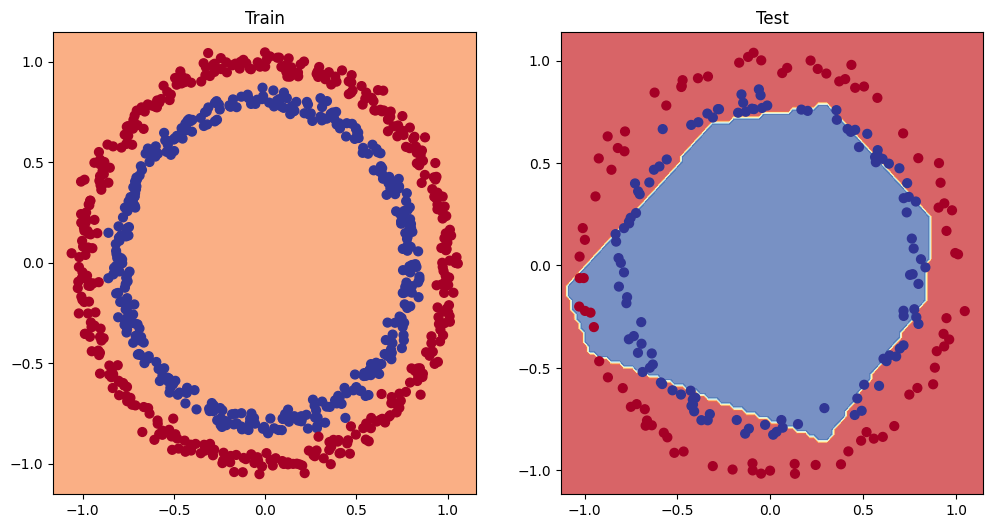

In [28]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_2, X_test, y_test) # model_3 = has non-linearity

In [29]:
def relu(x):
    return torch.maximum(torch.tensor(0), x)

def sigmoid(x):
    return 1/(1 + torch.exp(-x))

In [30]:
from sklearn.datasets import make_blobs

tensor([[ 1.4973, -7.4881],
        [ 2.9933, -8.0279],
        [ 0.9108, -6.8546],
        [ 0.9442, -8.2951],
        [-8.3546,  6.3835]]) tensor([3, 3, 3, 3, 0])


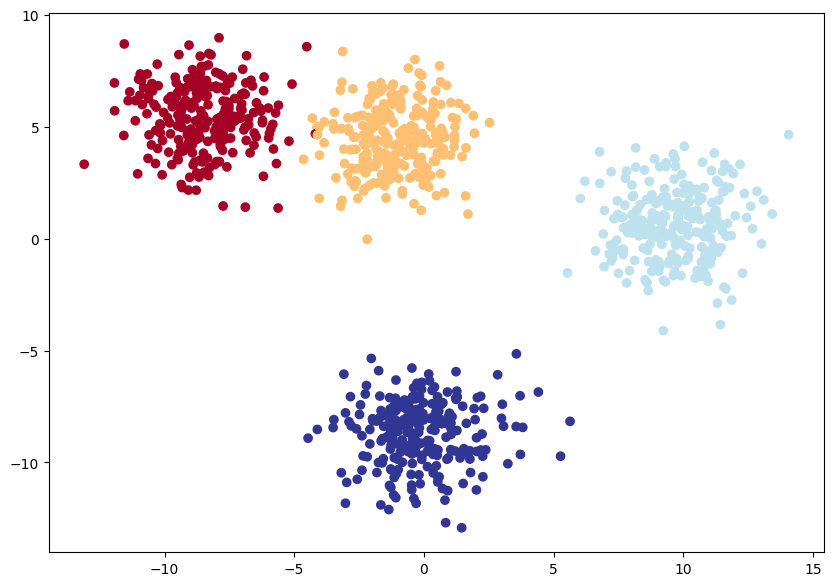

In [32]:
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 7

X_blob, y_blob = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels 
    cluster_std=1.5, # give the clusters a little shake up (try changing this to 1.0, the default)
    random_state=RANDOM_SEED
)

X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

In [34]:
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )

    def forward(self, x):
        return self.linear_layer_stack(x)
    
model_4 = BlobModel(input_features=NUM_FEATURES,
                    output_features=NUM_CLASSES,
                    hidden_units=8).to(device)

model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [35]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(), lr=0.1)

In [36]:
model_4(X_blob_train.to(device))[:5]

tensor([[-0.3250,  0.7803,  1.1565, -0.9936],
        [ 0.4576, -1.1173, -0.4628,  0.0875],
        [-0.2001,  1.2481,  0.0276,  0.1593],
        [-0.0836,  1.0812, -0.3439,  0.4671],
        [-0.1620,  1.4568, -0.3916,  0.5952]], device='mps:0',
       grad_fn=<SliceBackward0>)

In [37]:
model_4(X_blob_train.to(device))[0].shape, NUM_CLASSES

(torch.Size([4]), 4)

In [38]:
y_logits = model_4(X_blob_test.to(device))

y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.1767,  0.4501,  0.8163, -0.7512],
        [-0.0571,  0.9228, -0.2928,  0.3844],
        [ 0.3639, -0.5177, -0.6897,  0.4320],
        [ 0.0118,  0.8494, -0.5410,  0.5985],
        [ 0.3186, -0.5254, -0.4630,  0.2196]], device='mps:0',
       grad_fn=<SliceBackward0>)
tensor([[0.1630, 0.3051, 0.4401, 0.0918],
        [0.1664, 0.4433, 0.1315, 0.2588],
        [0.3530, 0.1462, 0.1231, 0.3778],
        [0.1759, 0.4065, 0.1012, 0.3163],
        [0.3580, 0.1539, 0.1638, 0.3242]], device='mps:0',
       grad_fn=<SliceBackward0>)


In [39]:
torch.sum(y_pred_probs[0])

tensor(1., device='mps:0', grad_fn=<SumBackward0>)

In [40]:
torch.manual_seed(7)

epochs = 100

X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    model_4.train()
    y_logits = model_4(X_blob_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_blob_train, y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_4.eval()
    with torch.inference_mode():
        test_logits = model_4(X_blob_test)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy_fn(y_blob_test, test_pred)
    if epoch%10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 1.75122, Acc: 25.87% | Test Loss: 1.00118, Test Acc: 48.00%
Epoch: 10 | Loss: 0.22439, Acc: 95.50% | Test Loss: 0.17384, Test Acc: 95.50%
Epoch: 20 | Loss: 0.12665, Acc: 97.25% | Test Loss: 0.10350, Test Acc: 97.50%
Epoch: 30 | Loss: 0.09462, Acc: 97.88% | Test Loss: 0.08309, Test Acc: 98.50%
Epoch: 40 | Loss: 0.07921, Acc: 97.88% | Test Loss: 0.07444, Test Acc: 98.00%
Epoch: 50 | Loss: 0.07001, Acc: 98.00% | Test Loss: 0.06980, Test Acc: 98.50%
Epoch: 60 | Loss: 0.06375, Acc: 98.00% | Test Loss: 0.06686, Test Acc: 98.50%
Epoch: 70 | Loss: 0.05909, Acc: 98.00% | Test Loss: 0.06475, Test Acc: 98.50%
Epoch: 80 | Loss: 0.05541, Acc: 98.00% | Test Loss: 0.06308, Test Acc: 98.50%
Epoch: 90 | Loss: 0.05236, Acc: 98.38% | Test Loss: 0.06166, Test Acc: 98.50%


In [41]:
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)


y_logits[:10]

tensor([[  1.6793,  -8.4089,  -1.3261,   8.9080],
        [-11.2045,   3.9155,   9.5268,  -0.3949],
        [  0.8328,   6.4779,  -2.0517,  -6.5116],
        [-12.2349,   6.4676,  10.2347,  -2.7868],
        [  2.5470,   4.0602,  -3.4161,  -4.4554],
        [-12.4654,   6.1541,  10.4834,  -2.3915],
        [-11.7043,   4.4904,   9.9379,  -0.8577],
        [  8.7313,   4.4820,  -9.2733,  -6.6568],
        [  8.9804,   3.0556,  -9.3617,  -5.2271],
        [  0.5952,  -8.6687,  -0.2804,   9.4894]], device='mps:0')

In [42]:
y_pred_probs = torch.softmax(y_logits, dim=1)
y_preds = y_pred_probs.argmax(dim=1)

print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([3, 2, 1, 2, 1, 2, 2, 0, 0, 3], device='mps:0')
Labels: tensor([3, 2, 1, 2, 1, 2, 2, 0, 0, 3], device='mps:0')
Test accuracy: 98.5%


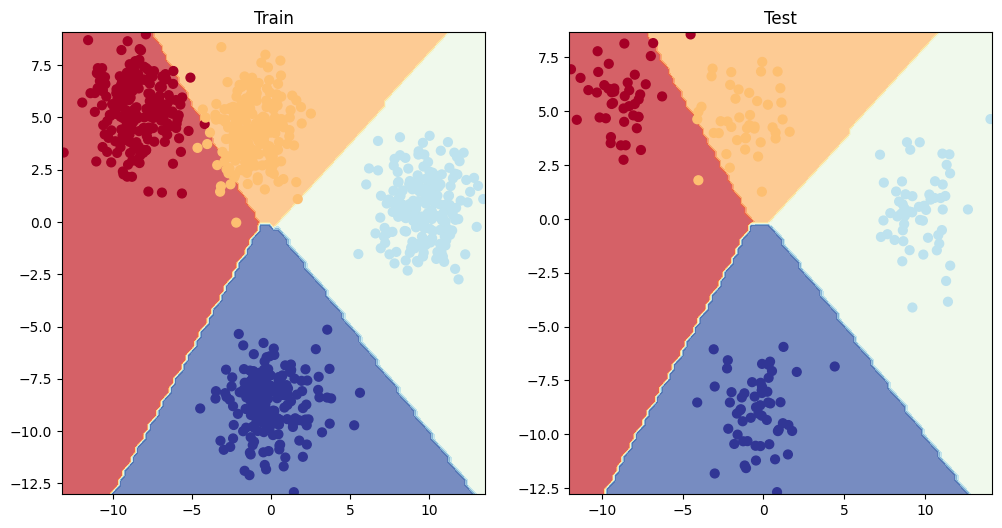

In [43]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)